# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


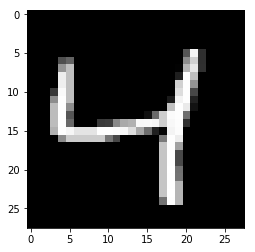

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [8]:
learning_rate = 0.001
# Input and target placeholders

inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x16
conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x8
conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(upsample1, 8, (3,3), padding='same')
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same')
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same')
# Now 28x28x16

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None) 
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='output')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [9]:
sess = tf.Session()

In [10]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.6905
Epoch: 1/20... Training loss: 0.6752
Epoch: 1/20... Training loss: 0.6564
Epoch: 1/20... Training loss: 0.6365
Epoch: 1/20... Training loss: 0.6147
Epoch: 1/20... Training loss: 0.5880
Epoch: 1/20... Training loss: 0.5650
Epoch: 1/20... Training loss: 0.5437
Epoch: 1/20... Training loss: 0.5360
Epoch: 1/20... Training loss: 0.5329
Epoch: 1/20... Training loss: 0.5479
Epoch: 1/20... Training loss: 0.5414
Epoch: 1/20... Training loss: 0.5195
Epoch: 1/20... Training loss: 0.5051
Epoch: 1/20... Training loss: 0.4963
Epoch: 1/20... Training loss: 0.4950
Epoch: 1/20... Training loss: 0.4718
Epoch: 1/20... Training loss: 0.4658
Epoch: 1/20... Training loss: 0.4601
Epoch: 1/20... Training loss: 0.4512
Epoch: 1/20... Training loss: 0.4435
Epoch: 1/20... Training loss: 0.4310
Epoch: 1/20... Training loss: 0.4263
Epoch: 1/20... Training loss: 0.4178
Epoch: 1/20... Training loss: 0.4081
Epoch: 1/20... Training loss: 0.3925
Epoch: 1/20... Training loss: 0.3775
E

Epoch: 1/20... Training loss: 0.1803
Epoch: 1/20... Training loss: 0.1858
Epoch: 1/20... Training loss: 0.1813
Epoch: 1/20... Training loss: 0.1813
Epoch: 1/20... Training loss: 0.1810
Epoch: 1/20... Training loss: 0.1820
Epoch: 1/20... Training loss: 0.1770
Epoch: 1/20... Training loss: 0.1861
Epoch: 1/20... Training loss: 0.1784
Epoch: 1/20... Training loss: 0.1780
Epoch: 1/20... Training loss: 0.1752
Epoch: 1/20... Training loss: 0.1815
Epoch: 1/20... Training loss: 0.1827
Epoch: 1/20... Training loss: 0.1840
Epoch: 1/20... Training loss: 0.1777
Epoch: 1/20... Training loss: 0.1755
Epoch: 1/20... Training loss: 0.1729
Epoch: 1/20... Training loss: 0.1779
Epoch: 1/20... Training loss: 0.1807
Epoch: 1/20... Training loss: 0.1847
Epoch: 1/20... Training loss: 0.1776
Epoch: 1/20... Training loss: 0.1797
Epoch: 1/20... Training loss: 0.1790
Epoch: 1/20... Training loss: 0.1766
Epoch: 1/20... Training loss: 0.1814
Epoch: 1/20... Training loss: 0.1814
Epoch: 1/20... Training loss: 0.1792
E

Epoch: 2/20... Training loss: 0.1634
Epoch: 2/20... Training loss: 0.1631
Epoch: 2/20... Training loss: 0.1612
Epoch: 2/20... Training loss: 0.1646
Epoch: 2/20... Training loss: 0.1635
Epoch: 2/20... Training loss: 0.1603
Epoch: 2/20... Training loss: 0.1620
Epoch: 2/20... Training loss: 0.1689
Epoch: 2/20... Training loss: 0.1626
Epoch: 2/20... Training loss: 0.1625
Epoch: 2/20... Training loss: 0.1704
Epoch: 2/20... Training loss: 0.1585
Epoch: 2/20... Training loss: 0.1607
Epoch: 2/20... Training loss: 0.1683
Epoch: 2/20... Training loss: 0.1582
Epoch: 2/20... Training loss: 0.1647
Epoch: 2/20... Training loss: 0.1624
Epoch: 2/20... Training loss: 0.1596
Epoch: 2/20... Training loss: 0.1650
Epoch: 2/20... Training loss: 0.1553
Epoch: 2/20... Training loss: 0.1620
Epoch: 2/20... Training loss: 0.1624
Epoch: 2/20... Training loss: 0.1638
Epoch: 2/20... Training loss: 0.1638
Epoch: 2/20... Training loss: 0.1624
Epoch: 2/20... Training loss: 0.1640
Epoch: 2/20... Training loss: 0.1588
E

Epoch: 3/20... Training loss: 0.1564
Epoch: 3/20... Training loss: 0.1521
Epoch: 3/20... Training loss: 0.1577
Epoch: 3/20... Training loss: 0.1563
Epoch: 3/20... Training loss: 0.1476
Epoch: 3/20... Training loss: 0.1518
Epoch: 3/20... Training loss: 0.1512
Epoch: 3/20... Training loss: 0.1528
Epoch: 3/20... Training loss: 0.1544
Epoch: 3/20... Training loss: 0.1573
Epoch: 3/20... Training loss: 0.1537
Epoch: 3/20... Training loss: 0.1521
Epoch: 3/20... Training loss: 0.1504
Epoch: 3/20... Training loss: 0.1550
Epoch: 3/20... Training loss: 0.1563
Epoch: 3/20... Training loss: 0.1537
Epoch: 3/20... Training loss: 0.1495
Epoch: 3/20... Training loss: 0.1459
Epoch: 3/20... Training loss: 0.1491
Epoch: 3/20... Training loss: 0.1477
Epoch: 3/20... Training loss: 0.1521
Epoch: 3/20... Training loss: 0.1562
Epoch: 3/20... Training loss: 0.1520
Epoch: 3/20... Training loss: 0.1516
Epoch: 3/20... Training loss: 0.1457
Epoch: 3/20... Training loss: 0.1497
Epoch: 3/20... Training loss: 0.1506
E

Epoch: 3/20... Training loss: 0.1464
Epoch: 3/20... Training loss: 0.1521
Epoch: 3/20... Training loss: 0.1402
Epoch: 3/20... Training loss: 0.1504
Epoch: 3/20... Training loss: 0.1414
Epoch: 3/20... Training loss: 0.1430
Epoch: 3/20... Training loss: 0.1437
Epoch: 3/20... Training loss: 0.1444
Epoch: 3/20... Training loss: 0.1424
Epoch: 3/20... Training loss: 0.1393
Epoch: 3/20... Training loss: 0.1492
Epoch: 3/20... Training loss: 0.1486
Epoch: 4/20... Training loss: 0.1370
Epoch: 4/20... Training loss: 0.1438
Epoch: 4/20... Training loss: 0.1484
Epoch: 4/20... Training loss: 0.1486
Epoch: 4/20... Training loss: 0.1430
Epoch: 4/20... Training loss: 0.1471
Epoch: 4/20... Training loss: 0.1447
Epoch: 4/20... Training loss: 0.1432
Epoch: 4/20... Training loss: 0.1414
Epoch: 4/20... Training loss: 0.1438
Epoch: 4/20... Training loss: 0.1402
Epoch: 4/20... Training loss: 0.1455
Epoch: 4/20... Training loss: 0.1449
Epoch: 4/20... Training loss: 0.1451
Epoch: 4/20... Training loss: 0.1396
E

Epoch: 4/20... Training loss: 0.1399
Epoch: 4/20... Training loss: 0.1383
Epoch: 4/20... Training loss: 0.1402
Epoch: 4/20... Training loss: 0.1411
Epoch: 4/20... Training loss: 0.1375
Epoch: 4/20... Training loss: 0.1412
Epoch: 4/20... Training loss: 0.1342
Epoch: 4/20... Training loss: 0.1404
Epoch: 4/20... Training loss: 0.1378
Epoch: 4/20... Training loss: 0.1405
Epoch: 4/20... Training loss: 0.1370
Epoch: 4/20... Training loss: 0.1400
Epoch: 4/20... Training loss: 0.1414
Epoch: 4/20... Training loss: 0.1395
Epoch: 4/20... Training loss: 0.1438
Epoch: 4/20... Training loss: 0.1416
Epoch: 4/20... Training loss: 0.1430
Epoch: 4/20... Training loss: 0.1374
Epoch: 4/20... Training loss: 0.1349
Epoch: 4/20... Training loss: 0.1405
Epoch: 4/20... Training loss: 0.1367
Epoch: 4/20... Training loss: 0.1373
Epoch: 4/20... Training loss: 0.1374
Epoch: 4/20... Training loss: 0.1397
Epoch: 4/20... Training loss: 0.1394
Epoch: 4/20... Training loss: 0.1347
Epoch: 4/20... Training loss: 0.1399
E

Epoch: 5/20... Training loss: 0.1360
Epoch: 5/20... Training loss: 0.1371
Epoch: 5/20... Training loss: 0.1349
Epoch: 5/20... Training loss: 0.1387
Epoch: 5/20... Training loss: 0.1337
Epoch: 5/20... Training loss: 0.1385
Epoch: 5/20... Training loss: 0.1346
Epoch: 5/20... Training loss: 0.1342
Epoch: 5/20... Training loss: 0.1425
Epoch: 5/20... Training loss: 0.1370
Epoch: 5/20... Training loss: 0.1347
Epoch: 5/20... Training loss: 0.1371
Epoch: 5/20... Training loss: 0.1372
Epoch: 5/20... Training loss: 0.1372
Epoch: 5/20... Training loss: 0.1361
Epoch: 5/20... Training loss: 0.1320
Epoch: 5/20... Training loss: 0.1354
Epoch: 5/20... Training loss: 0.1371
Epoch: 5/20... Training loss: 0.1368
Epoch: 5/20... Training loss: 0.1329
Epoch: 5/20... Training loss: 0.1417
Epoch: 5/20... Training loss: 0.1421
Epoch: 5/20... Training loss: 0.1312
Epoch: 5/20... Training loss: 0.1350
Epoch: 5/20... Training loss: 0.1315
Epoch: 5/20... Training loss: 0.1310
Epoch: 5/20... Training loss: 0.1359
E

Epoch: 6/20... Training loss: 0.1273
Epoch: 6/20... Training loss: 0.1297
Epoch: 6/20... Training loss: 0.1317
Epoch: 6/20... Training loss: 0.1362
Epoch: 6/20... Training loss: 0.1298
Epoch: 6/20... Training loss: 0.1318
Epoch: 6/20... Training loss: 0.1282
Epoch: 6/20... Training loss: 0.1316
Epoch: 6/20... Training loss: 0.1316
Epoch: 6/20... Training loss: 0.1279
Epoch: 6/20... Training loss: 0.1352
Epoch: 6/20... Training loss: 0.1358
Epoch: 6/20... Training loss: 0.1348
Epoch: 6/20... Training loss: 0.1331
Epoch: 6/20... Training loss: 0.1308
Epoch: 6/20... Training loss: 0.1334
Epoch: 6/20... Training loss: 0.1328
Epoch: 6/20... Training loss: 0.1361
Epoch: 6/20... Training loss: 0.1303
Epoch: 6/20... Training loss: 0.1354
Epoch: 6/20... Training loss: 0.1362
Epoch: 6/20... Training loss: 0.1291
Epoch: 6/20... Training loss: 0.1290
Epoch: 6/20... Training loss: 0.1262
Epoch: 6/20... Training loss: 0.1347
Epoch: 6/20... Training loss: 0.1356
Epoch: 6/20... Training loss: 0.1310
E

Epoch: 6/20... Training loss: 0.1258
Epoch: 6/20... Training loss: 0.1293
Epoch: 6/20... Training loss: 0.1283
Epoch: 6/20... Training loss: 0.1289
Epoch: 6/20... Training loss: 0.1311
Epoch: 6/20... Training loss: 0.1324
Epoch: 6/20... Training loss: 0.1321
Epoch: 6/20... Training loss: 0.1320
Epoch: 6/20... Training loss: 0.1282
Epoch: 6/20... Training loss: 0.1316
Epoch: 6/20... Training loss: 0.1376
Epoch: 6/20... Training loss: 0.1269
Epoch: 6/20... Training loss: 0.1326
Epoch: 6/20... Training loss: 0.1310
Epoch: 6/20... Training loss: 0.1286
Epoch: 6/20... Training loss: 0.1319
Epoch: 6/20... Training loss: 0.1317
Epoch: 6/20... Training loss: 0.1261
Epoch: 6/20... Training loss: 0.1310
Epoch: 6/20... Training loss: 0.1247
Epoch: 6/20... Training loss: 0.1293
Epoch: 6/20... Training loss: 0.1310
Epoch: 6/20... Training loss: 0.1314
Epoch: 6/20... Training loss: 0.1274
Epoch: 7/20... Training loss: 0.1337
Epoch: 7/20... Training loss: 0.1281
Epoch: 7/20... Training loss: 0.1342
E

Epoch: 7/20... Training loss: 0.1286
Epoch: 7/20... Training loss: 0.1307
Epoch: 7/20... Training loss: 0.1263
Epoch: 7/20... Training loss: 0.1265
Epoch: 7/20... Training loss: 0.1312
Epoch: 7/20... Training loss: 0.1304
Epoch: 7/20... Training loss: 0.1291
Epoch: 7/20... Training loss: 0.1285
Epoch: 7/20... Training loss: 0.1268
Epoch: 7/20... Training loss: 0.1302
Epoch: 7/20... Training loss: 0.1231
Epoch: 7/20... Training loss: 0.1252
Epoch: 7/20... Training loss: 0.1272
Epoch: 7/20... Training loss: 0.1296
Epoch: 7/20... Training loss: 0.1255
Epoch: 7/20... Training loss: 0.1287
Epoch: 7/20... Training loss: 0.1317
Epoch: 7/20... Training loss: 0.1300
Epoch: 7/20... Training loss: 0.1285
Epoch: 7/20... Training loss: 0.1277
Epoch: 7/20... Training loss: 0.1270
Epoch: 7/20... Training loss: 0.1314
Epoch: 7/20... Training loss: 0.1269
Epoch: 7/20... Training loss: 0.1262
Epoch: 7/20... Training loss: 0.1303
Epoch: 7/20... Training loss: 0.1262
Epoch: 7/20... Training loss: 0.1242
E

Epoch: 8/20... Training loss: 0.1307
Epoch: 8/20... Training loss: 0.1230
Epoch: 8/20... Training loss: 0.1254
Epoch: 8/20... Training loss: 0.1246
Epoch: 8/20... Training loss: 0.1300
Epoch: 8/20... Training loss: 0.1224
Epoch: 8/20... Training loss: 0.1230
Epoch: 8/20... Training loss: 0.1298
Epoch: 8/20... Training loss: 0.1280
Epoch: 8/20... Training loss: 0.1209
Epoch: 8/20... Training loss: 0.1292
Epoch: 8/20... Training loss: 0.1310
Epoch: 8/20... Training loss: 0.1277
Epoch: 8/20... Training loss: 0.1215
Epoch: 8/20... Training loss: 0.1301
Epoch: 8/20... Training loss: 0.1232
Epoch: 8/20... Training loss: 0.1262
Epoch: 8/20... Training loss: 0.1250
Epoch: 8/20... Training loss: 0.1259
Epoch: 8/20... Training loss: 0.1247
Epoch: 8/20... Training loss: 0.1300
Epoch: 8/20... Training loss: 0.1292
Epoch: 8/20... Training loss: 0.1278
Epoch: 8/20... Training loss: 0.1278
Epoch: 8/20... Training loss: 0.1308
Epoch: 8/20... Training loss: 0.1228
Epoch: 8/20... Training loss: 0.1241
E

Epoch: 9/20... Training loss: 0.1233
Epoch: 9/20... Training loss: 0.1270
Epoch: 9/20... Training loss: 0.1247
Epoch: 9/20... Training loss: 0.1254
Epoch: 9/20... Training loss: 0.1283
Epoch: 9/20... Training loss: 0.1267
Epoch: 9/20... Training loss: 0.1253
Epoch: 9/20... Training loss: 0.1260
Epoch: 9/20... Training loss: 0.1230
Epoch: 9/20... Training loss: 0.1274
Epoch: 9/20... Training loss: 0.1223
Epoch: 9/20... Training loss: 0.1256
Epoch: 9/20... Training loss: 0.1228
Epoch: 9/20... Training loss: 0.1260
Epoch: 9/20... Training loss: 0.1322
Epoch: 9/20... Training loss: 0.1211
Epoch: 9/20... Training loss: 0.1248
Epoch: 9/20... Training loss: 0.1259
Epoch: 9/20... Training loss: 0.1262
Epoch: 9/20... Training loss: 0.1239
Epoch: 9/20... Training loss: 0.1203
Epoch: 9/20... Training loss: 0.1252
Epoch: 9/20... Training loss: 0.1248
Epoch: 9/20... Training loss: 0.1241
Epoch: 9/20... Training loss: 0.1237
Epoch: 9/20... Training loss: 0.1219
Epoch: 9/20... Training loss: 0.1279
E

Epoch: 9/20... Training loss: 0.1263
Epoch: 9/20... Training loss: 0.1198
Epoch: 9/20... Training loss: 0.1220
Epoch: 9/20... Training loss: 0.1239
Epoch: 9/20... Training loss: 0.1245
Epoch: 9/20... Training loss: 0.1276
Epoch: 9/20... Training loss: 0.1179
Epoch: 9/20... Training loss: 0.1236
Epoch: 9/20... Training loss: 0.1225
Epoch: 9/20... Training loss: 0.1250
Epoch: 9/20... Training loss: 0.1293
Epoch: 9/20... Training loss: 0.1239
Epoch: 9/20... Training loss: 0.1218
Epoch: 9/20... Training loss: 0.1284
Epoch: 9/20... Training loss: 0.1245
Epoch: 9/20... Training loss: 0.1288
Epoch: 9/20... Training loss: 0.1245
Epoch: 9/20... Training loss: 0.1261
Epoch: 9/20... Training loss: 0.1250
Epoch: 9/20... Training loss: 0.1217
Epoch: 9/20... Training loss: 0.1285
Epoch: 9/20... Training loss: 0.1267
Epoch: 9/20... Training loss: 0.1294
Epoch: 9/20... Training loss: 0.1247
Epoch: 9/20... Training loss: 0.1298
Epoch: 9/20... Training loss: 0.1246
Epoch: 9/20... Training loss: 0.1203
E

Epoch: 10/20... Training loss: 0.1248
Epoch: 10/20... Training loss: 0.1246
Epoch: 10/20... Training loss: 0.1235
Epoch: 10/20... Training loss: 0.1254
Epoch: 10/20... Training loss: 0.1264
Epoch: 10/20... Training loss: 0.1177
Epoch: 10/20... Training loss: 0.1250
Epoch: 10/20... Training loss: 0.1262
Epoch: 10/20... Training loss: 0.1272
Epoch: 10/20... Training loss: 0.1223
Epoch: 10/20... Training loss: 0.1251
Epoch: 10/20... Training loss: 0.1256
Epoch: 10/20... Training loss: 0.1257
Epoch: 10/20... Training loss: 0.1261
Epoch: 10/20... Training loss: 0.1252
Epoch: 10/20... Training loss: 0.1288
Epoch: 10/20... Training loss: 0.1195
Epoch: 10/20... Training loss: 0.1271
Epoch: 10/20... Training loss: 0.1271
Epoch: 10/20... Training loss: 0.1265
Epoch: 10/20... Training loss: 0.1276
Epoch: 10/20... Training loss: 0.1245
Epoch: 10/20... Training loss: 0.1207
Epoch: 10/20... Training loss: 0.1244
Epoch: 10/20... Training loss: 0.1244
Epoch: 10/20... Training loss: 0.1254
Epoch: 10/20

Epoch: 11/20... Training loss: 0.1216
Epoch: 11/20... Training loss: 0.1251
Epoch: 11/20... Training loss: 0.1187
Epoch: 11/20... Training loss: 0.1247
Epoch: 11/20... Training loss: 0.1248
Epoch: 11/20... Training loss: 0.1237
Epoch: 11/20... Training loss: 0.1220
Epoch: 11/20... Training loss: 0.1263
Epoch: 11/20... Training loss: 0.1257
Epoch: 11/20... Training loss: 0.1201
Epoch: 11/20... Training loss: 0.1216
Epoch: 11/20... Training loss: 0.1218
Epoch: 11/20... Training loss: 0.1175
Epoch: 11/20... Training loss: 0.1235
Epoch: 11/20... Training loss: 0.1209
Epoch: 11/20... Training loss: 0.1276
Epoch: 11/20... Training loss: 0.1228
Epoch: 11/20... Training loss: 0.1225
Epoch: 11/20... Training loss: 0.1236
Epoch: 11/20... Training loss: 0.1259
Epoch: 11/20... Training loss: 0.1220
Epoch: 11/20... Training loss: 0.1245
Epoch: 11/20... Training loss: 0.1269
Epoch: 11/20... Training loss: 0.1225
Epoch: 11/20... Training loss: 0.1232
Epoch: 11/20... Training loss: 0.1235
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1252
Epoch: 12/20... Training loss: 0.1260
Epoch: 12/20... Training loss: 0.1259
Epoch: 12/20... Training loss: 0.1210
Epoch: 12/20... Training loss: 0.1239
Epoch: 12/20... Training loss: 0.1201
Epoch: 12/20... Training loss: 0.1253
Epoch: 12/20... Training loss: 0.1238
Epoch: 12/20... Training loss: 0.1210
Epoch: 12/20... Training loss: 0.1241
Epoch: 12/20... Training loss: 0.1237
Epoch: 12/20... Training loss: 0.1222
Epoch: 12/20... Training loss: 0.1183
Epoch: 12/20... Training loss: 0.1228
Epoch: 12/20... Training loss: 0.1234
Epoch: 12/20... Training loss: 0.1202
Epoch: 12/20... Training loss: 0.1180
Epoch: 12/20... Training loss: 0.1221
Epoch: 12/20... Training loss: 0.1198
Epoch: 12/20... Training loss: 0.1223
Epoch: 12/20... Training loss: 0.1236
Epoch: 12/20... Training loss: 0.1226
Epoch: 12/20... Training loss: 0.1252
Epoch: 12/20... Training loss: 0.1242
Epoch: 12/20... Training loss: 0.1238
Epoch: 12/20... Training loss: 0.1225
Epoch: 12/20

Epoch: 12/20... Training loss: 0.1140
Epoch: 12/20... Training loss: 0.1187
Epoch: 12/20... Training loss: 0.1209
Epoch: 12/20... Training loss: 0.1208
Epoch: 12/20... Training loss: 0.1222
Epoch: 12/20... Training loss: 0.1219
Epoch: 12/20... Training loss: 0.1256
Epoch: 12/20... Training loss: 0.1238
Epoch: 12/20... Training loss: 0.1235
Epoch: 12/20... Training loss: 0.1215
Epoch: 12/20... Training loss: 0.1189
Epoch: 12/20... Training loss: 0.1206
Epoch: 12/20... Training loss: 0.1242
Epoch: 12/20... Training loss: 0.1177
Epoch: 12/20... Training loss: 0.1213
Epoch: 12/20... Training loss: 0.1241
Epoch: 12/20... Training loss: 0.1273
Epoch: 12/20... Training loss: 0.1169
Epoch: 12/20... Training loss: 0.1211
Epoch: 12/20... Training loss: 0.1226
Epoch: 12/20... Training loss: 0.1231
Epoch: 12/20... Training loss: 0.1222
Epoch: 12/20... Training loss: 0.1228
Epoch: 12/20... Training loss: 0.1233
Epoch: 12/20... Training loss: 0.1288
Epoch: 12/20... Training loss: 0.1158
Epoch: 12/20

Epoch: 13/20... Training loss: 0.1213
Epoch: 13/20... Training loss: 0.1202
Epoch: 13/20... Training loss: 0.1210
Epoch: 13/20... Training loss: 0.1211
Epoch: 13/20... Training loss: 0.1215
Epoch: 13/20... Training loss: 0.1173
Epoch: 13/20... Training loss: 0.1178
Epoch: 13/20... Training loss: 0.1200
Epoch: 13/20... Training loss: 0.1225
Epoch: 13/20... Training loss: 0.1211
Epoch: 13/20... Training loss: 0.1206
Epoch: 13/20... Training loss: 0.1214
Epoch: 13/20... Training loss: 0.1219
Epoch: 13/20... Training loss: 0.1244
Epoch: 13/20... Training loss: 0.1260
Epoch: 13/20... Training loss: 0.1173
Epoch: 13/20... Training loss: 0.1218
Epoch: 13/20... Training loss: 0.1200
Epoch: 13/20... Training loss: 0.1167
Epoch: 13/20... Training loss: 0.1262
Epoch: 13/20... Training loss: 0.1231
Epoch: 13/20... Training loss: 0.1216
Epoch: 13/20... Training loss: 0.1203
Epoch: 13/20... Training loss: 0.1216
Epoch: 13/20... Training loss: 0.1211
Epoch: 13/20... Training loss: 0.1181
Epoch: 13/20

Epoch: 14/20... Training loss: 0.1244
Epoch: 14/20... Training loss: 0.1232
Epoch: 14/20... Training loss: 0.1203
Epoch: 14/20... Training loss: 0.1224
Epoch: 14/20... Training loss: 0.1216
Epoch: 14/20... Training loss: 0.1225
Epoch: 14/20... Training loss: 0.1154
Epoch: 14/20... Training loss: 0.1192
Epoch: 14/20... Training loss: 0.1159
Epoch: 14/20... Training loss: 0.1208
Epoch: 14/20... Training loss: 0.1196
Epoch: 14/20... Training loss: 0.1225
Epoch: 14/20... Training loss: 0.1217
Epoch: 14/20... Training loss: 0.1201
Epoch: 14/20... Training loss: 0.1174
Epoch: 14/20... Training loss: 0.1205
Epoch: 14/20... Training loss: 0.1197
Epoch: 14/20... Training loss: 0.1212
Epoch: 14/20... Training loss: 0.1161
Epoch: 14/20... Training loss: 0.1208
Epoch: 14/20... Training loss: 0.1206
Epoch: 14/20... Training loss: 0.1203
Epoch: 14/20... Training loss: 0.1160
Epoch: 14/20... Training loss: 0.1183
Epoch: 14/20... Training loss: 0.1231
Epoch: 14/20... Training loss: 0.1216
Epoch: 14/20

Epoch: 14/20... Training loss: 0.1195
Epoch: 14/20... Training loss: 0.1200
Epoch: 14/20... Training loss: 0.1194
Epoch: 14/20... Training loss: 0.1188
Epoch: 14/20... Training loss: 0.1198
Epoch: 14/20... Training loss: 0.1202
Epoch: 14/20... Training loss: 0.1173
Epoch: 14/20... Training loss: 0.1202
Epoch: 14/20... Training loss: 0.1235
Epoch: 14/20... Training loss: 0.1204
Epoch: 14/20... Training loss: 0.1134
Epoch: 14/20... Training loss: 0.1191
Epoch: 14/20... Training loss: 0.1209
Epoch: 14/20... Training loss: 0.1207
Epoch: 14/20... Training loss: 0.1205
Epoch: 14/20... Training loss: 0.1233
Epoch: 14/20... Training loss: 0.1203
Epoch: 14/20... Training loss: 0.1217
Epoch: 14/20... Training loss: 0.1205
Epoch: 14/20... Training loss: 0.1210
Epoch: 14/20... Training loss: 0.1186
Epoch: 14/20... Training loss: 0.1206
Epoch: 14/20... Training loss: 0.1171
Epoch: 15/20... Training loss: 0.1177
Epoch: 15/20... Training loss: 0.1213
Epoch: 15/20... Training loss: 0.1228
Epoch: 15/20

Epoch: 15/20... Training loss: 0.1186
Epoch: 15/20... Training loss: 0.1204
Epoch: 15/20... Training loss: 0.1209
Epoch: 15/20... Training loss: 0.1208
Epoch: 15/20... Training loss: 0.1191
Epoch: 15/20... Training loss: 0.1166
Epoch: 15/20... Training loss: 0.1225
Epoch: 15/20... Training loss: 0.1263
Epoch: 15/20... Training loss: 0.1247
Epoch: 15/20... Training loss: 0.1207
Epoch: 15/20... Training loss: 0.1212
Epoch: 15/20... Training loss: 0.1229
Epoch: 15/20... Training loss: 0.1175
Epoch: 15/20... Training loss: 0.1232
Epoch: 15/20... Training loss: 0.1227
Epoch: 15/20... Training loss: 0.1162
Epoch: 15/20... Training loss: 0.1212
Epoch: 15/20... Training loss: 0.1223
Epoch: 15/20... Training loss: 0.1165
Epoch: 15/20... Training loss: 0.1193
Epoch: 15/20... Training loss: 0.1220
Epoch: 15/20... Training loss: 0.1224
Epoch: 15/20... Training loss: 0.1240
Epoch: 15/20... Training loss: 0.1206
Epoch: 15/20... Training loss: 0.1202
Epoch: 15/20... Training loss: 0.1202
Epoch: 15/20

Epoch: 16/20... Training loss: 0.1255
Epoch: 16/20... Training loss: 0.1199
Epoch: 16/20... Training loss: 0.1187
Epoch: 16/20... Training loss: 0.1191
Epoch: 16/20... Training loss: 0.1216
Epoch: 16/20... Training loss: 0.1168
Epoch: 16/20... Training loss: 0.1211
Epoch: 16/20... Training loss: 0.1208
Epoch: 16/20... Training loss: 0.1169
Epoch: 16/20... Training loss: 0.1183
Epoch: 16/20... Training loss: 0.1213
Epoch: 16/20... Training loss: 0.1203
Epoch: 16/20... Training loss: 0.1244
Epoch: 16/20... Training loss: 0.1198
Epoch: 16/20... Training loss: 0.1166
Epoch: 16/20... Training loss: 0.1218
Epoch: 16/20... Training loss: 0.1165
Epoch: 16/20... Training loss: 0.1222
Epoch: 16/20... Training loss: 0.1183
Epoch: 16/20... Training loss: 0.1247
Epoch: 16/20... Training loss: 0.1257
Epoch: 16/20... Training loss: 0.1267
Epoch: 16/20... Training loss: 0.1189
Epoch: 16/20... Training loss: 0.1149
Epoch: 16/20... Training loss: 0.1133
Epoch: 16/20... Training loss: 0.1218
Epoch: 16/20

Epoch: 17/20... Training loss: 0.1199
Epoch: 17/20... Training loss: 0.1210
Epoch: 17/20... Training loss: 0.1210
Epoch: 17/20... Training loss: 0.1187
Epoch: 17/20... Training loss: 0.1195
Epoch: 17/20... Training loss: 0.1213
Epoch: 17/20... Training loss: 0.1167
Epoch: 17/20... Training loss: 0.1166
Epoch: 17/20... Training loss: 0.1240
Epoch: 17/20... Training loss: 0.1155
Epoch: 17/20... Training loss: 0.1181
Epoch: 17/20... Training loss: 0.1214
Epoch: 17/20... Training loss: 0.1171
Epoch: 17/20... Training loss: 0.1206
Epoch: 17/20... Training loss: 0.1195
Epoch: 17/20... Training loss: 0.1188
Epoch: 17/20... Training loss: 0.1179
Epoch: 17/20... Training loss: 0.1208
Epoch: 17/20... Training loss: 0.1164
Epoch: 17/20... Training loss: 0.1175
Epoch: 17/20... Training loss: 0.1188
Epoch: 17/20... Training loss: 0.1173
Epoch: 17/20... Training loss: 0.1214
Epoch: 17/20... Training loss: 0.1183
Epoch: 17/20... Training loss: 0.1204
Epoch: 17/20... Training loss: 0.1192
Epoch: 17/20

Epoch: 17/20... Training loss: 0.1204
Epoch: 17/20... Training loss: 0.1175
Epoch: 17/20... Training loss: 0.1218
Epoch: 17/20... Training loss: 0.1226
Epoch: 17/20... Training loss: 0.1196
Epoch: 17/20... Training loss: 0.1203
Epoch: 17/20... Training loss: 0.1214
Epoch: 17/20... Training loss: 0.1168
Epoch: 17/20... Training loss: 0.1215
Epoch: 17/20... Training loss: 0.1198
Epoch: 17/20... Training loss: 0.1215
Epoch: 17/20... Training loss: 0.1167
Epoch: 17/20... Training loss: 0.1252
Epoch: 17/20... Training loss: 0.1228
Epoch: 17/20... Training loss: 0.1158
Epoch: 17/20... Training loss: 0.1232
Epoch: 17/20... Training loss: 0.1168
Epoch: 17/20... Training loss: 0.1234
Epoch: 17/20... Training loss: 0.1167
Epoch: 17/20... Training loss: 0.1188
Epoch: 17/20... Training loss: 0.1230
Epoch: 17/20... Training loss: 0.1184
Epoch: 17/20... Training loss: 0.1189
Epoch: 17/20... Training loss: 0.1195
Epoch: 17/20... Training loss: 0.1170
Epoch: 17/20... Training loss: 0.1242
Epoch: 17/20

Epoch: 18/20... Training loss: 0.1168
Epoch: 18/20... Training loss: 0.1241
Epoch: 18/20... Training loss: 0.1245
Epoch: 18/20... Training loss: 0.1199
Epoch: 18/20... Training loss: 0.1218
Epoch: 18/20... Training loss: 0.1184
Epoch: 18/20... Training loss: 0.1192
Epoch: 18/20... Training loss: 0.1199
Epoch: 18/20... Training loss: 0.1177
Epoch: 18/20... Training loss: 0.1166
Epoch: 18/20... Training loss: 0.1220
Epoch: 18/20... Training loss: 0.1196
Epoch: 18/20... Training loss: 0.1193
Epoch: 18/20... Training loss: 0.1204
Epoch: 18/20... Training loss: 0.1183
Epoch: 18/20... Training loss: 0.1178
Epoch: 18/20... Training loss: 0.1181
Epoch: 18/20... Training loss: 0.1201
Epoch: 18/20... Training loss: 0.1165
Epoch: 18/20... Training loss: 0.1178
Epoch: 18/20... Training loss: 0.1197
Epoch: 18/20... Training loss: 0.1195
Epoch: 18/20... Training loss: 0.1134
Epoch: 18/20... Training loss: 0.1208
Epoch: 18/20... Training loss: 0.1189
Epoch: 18/20... Training loss: 0.1186
Epoch: 18/20

Epoch: 19/20... Training loss: 0.1153
Epoch: 19/20... Training loss: 0.1208
Epoch: 19/20... Training loss: 0.1232
Epoch: 19/20... Training loss: 0.1200
Epoch: 19/20... Training loss: 0.1188
Epoch: 19/20... Training loss: 0.1163
Epoch: 19/20... Training loss: 0.1165
Epoch: 19/20... Training loss: 0.1243
Epoch: 19/20... Training loss: 0.1173
Epoch: 19/20... Training loss: 0.1175
Epoch: 19/20... Training loss: 0.1189
Epoch: 19/20... Training loss: 0.1199
Epoch: 19/20... Training loss: 0.1189
Epoch: 19/20... Training loss: 0.1217
Epoch: 19/20... Training loss: 0.1200
Epoch: 19/20... Training loss: 0.1169
Epoch: 19/20... Training loss: 0.1154
Epoch: 19/20... Training loss: 0.1158
Epoch: 19/20... Training loss: 0.1191
Epoch: 19/20... Training loss: 0.1209
Epoch: 19/20... Training loss: 0.1228
Epoch: 19/20... Training loss: 0.1170
Epoch: 19/20... Training loss: 0.1196
Epoch: 19/20... Training loss: 0.1236
Epoch: 19/20... Training loss: 0.1164
Epoch: 19/20... Training loss: 0.1196
Epoch: 19/20

Epoch: 19/20... Training loss: 0.1185
Epoch: 19/20... Training loss: 0.1181
Epoch: 19/20... Training loss: 0.1188
Epoch: 19/20... Training loss: 0.1200
Epoch: 19/20... Training loss: 0.1203
Epoch: 19/20... Training loss: 0.1127
Epoch: 19/20... Training loss: 0.1184
Epoch: 19/20... Training loss: 0.1186
Epoch: 19/20... Training loss: 0.1150
Epoch: 19/20... Training loss: 0.1147
Epoch: 19/20... Training loss: 0.1166
Epoch: 20/20... Training loss: 0.1147
Epoch: 20/20... Training loss: 0.1157
Epoch: 20/20... Training loss: 0.1201
Epoch: 20/20... Training loss: 0.1158
Epoch: 20/20... Training loss: 0.1204
Epoch: 20/20... Training loss: 0.1190
Epoch: 20/20... Training loss: 0.1214
Epoch: 20/20... Training loss: 0.1174
Epoch: 20/20... Training loss: 0.1142
Epoch: 20/20... Training loss: 0.1197
Epoch: 20/20... Training loss: 0.1173
Epoch: 20/20... Training loss: 0.1182
Epoch: 20/20... Training loss: 0.1230
Epoch: 20/20... Training loss: 0.1178
Epoch: 20/20... Training loss: 0.1134
Epoch: 20/20

Epoch: 20/20... Training loss: 0.1179
Epoch: 20/20... Training loss: 0.1155
Epoch: 20/20... Training loss: 0.1152
Epoch: 20/20... Training loss: 0.1219
Epoch: 20/20... Training loss: 0.1213
Epoch: 20/20... Training loss: 0.1166
Epoch: 20/20... Training loss: 0.1156
Epoch: 20/20... Training loss: 0.1194
Epoch: 20/20... Training loss: 0.1214
Epoch: 20/20... Training loss: 0.1163
Epoch: 20/20... Training loss: 0.1175
Epoch: 20/20... Training loss: 0.1166
Epoch: 20/20... Training loss: 0.1174
Epoch: 20/20... Training loss: 0.1211
Epoch: 20/20... Training loss: 0.1171
Epoch: 20/20... Training loss: 0.1224
Epoch: 20/20... Training loss: 0.1160
Epoch: 20/20... Training loss: 0.1158
Epoch: 20/20... Training loss: 0.1213
Epoch: 20/20... Training loss: 0.1159
Epoch: 20/20... Training loss: 0.1158
Epoch: 20/20... Training loss: 0.1177
Epoch: 20/20... Training loss: 0.1138
Epoch: 20/20... Training loss: 0.1197
Epoch: 20/20... Training loss: 0.1198
Epoch: 20/20... Training loss: 0.1191
Epoch: 20/20

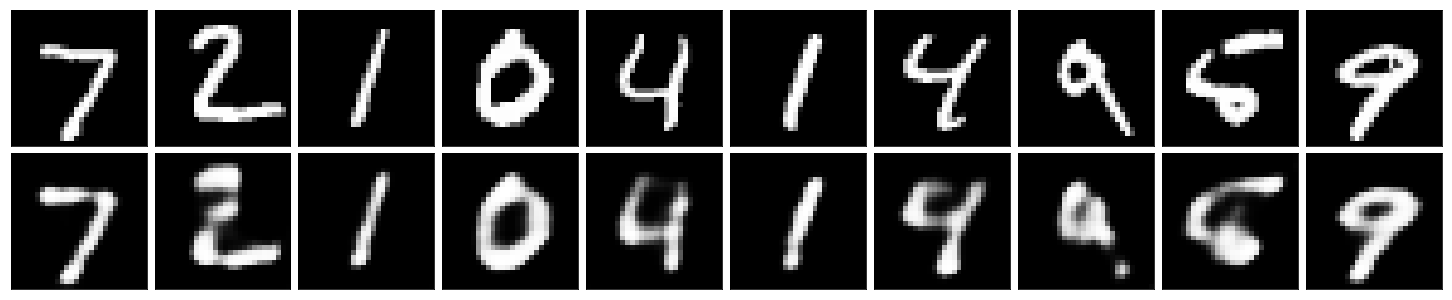

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [12]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [20]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.nn.sigmoid(logits, name='decoded')

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_,logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [21]:
sess = tf.Session()

In [22]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/100... Training loss: 0.6894
Epoch: 1/100... Training loss: 0.6674
Epoch: 1/100... Training loss: 0.6385
Epoch: 1/100... Training loss: 0.5992
Epoch: 1/100... Training loss: 0.5539
Epoch: 1/100... Training loss: 0.5092
Epoch: 1/100... Training loss: 0.4936
Epoch: 1/100... Training loss: 0.5195
Epoch: 1/100... Training loss: 0.5023
Epoch: 1/100... Training loss: 0.4949
Epoch: 1/100... Training loss: 0.4868
Epoch: 1/100... Training loss: 0.4721
Epoch: 1/100... Training loss: 0.4713
Epoch: 1/100... Training loss: 0.4712
Epoch: 1/100... Training loss: 0.4597
Epoch: 1/100... Training loss: 0.4593
Epoch: 1/100... Training loss: 0.4535
Epoch: 1/100... Training loss: 0.4363
Epoch: 1/100... Training loss: 0.4258
Epoch: 1/100... Training loss: 0.4238
Epoch: 1/100... Training loss: 0.4144
Epoch: 1/100... Training loss: 0.4104
Epoch: 1/100... Training loss: 0.3944
Epoch: 1/100... Training loss: 0.3797
Epoch: 1/100... Training loss: 0.3642
Epoch: 1/100... Training loss: 0.3600
Epoch: 1/100

KeyboardInterrupt: 

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)